# Transfer Learning

Tranfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

* Pretrained model = foundation models

In [1]:
import torch
import torchvision

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


Import the code written in previous sections so that we don't have to write it all again.

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular import data_setup, engine
except:
  print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
  !git clone https://github.com/almosenja/PyTorch
  !mv PyTorch/going_modular .
  !rm -rf PyTorch/
  from going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'PyTorch'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 36 (delta 9), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (36/36), 4.28 MiB | 10.46 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [5]:
import os
import zipfile
import requests
from pathlib import Path

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Id the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exits, skipping re-download.")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download the data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip the data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi, downloading it...
Unzipping pizza, steak, sushi data...


In [6]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

### 2.1. Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

In [7]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([transforms.Resize(size=(224, 224)),
                                        transforms.ToTensor(),
                                        normalize])

In [8]:
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e0300dc6920>,
 ['pizza', 'steak', 'sushi'])

### 2.2. Creating a transform for `torchvision.models` (auto creation)

In [9]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e03007348e0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

### 3.1. Which pretrained model should we use?

Three things to consider:
1. Speed - how fast does it run?
2. Size - how big is the model?
3. Performance - how well does it go on the chosen problem?

### 3.2. Setting up a pretrained model

Want to create an instance of a pretrained EfficientNetB0

In [20]:
import torchvision
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# Use this function to prevent error
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

# New method of creating a pretrained model
model = torchvision.models.efficientnet_b0(weights="DEFAULT").to(device) # Default -> ImageNet

### 3.3. Getting a summary of the model with `torchinfo.summary()`

In [21]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4. Freezing the base model and changing the output layer to suit our needs

In [22]:
# Freeze all of the base layers EfficientNetB0
for param in model.features.parameters():
  param.requires_grad = False # This frozen all the features parameters

In [23]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)

In [24]:
# Check the summary again
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [25]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
# Import train function
from going_modular import engine, utils

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds.")

# Save the model
utils.save_model(model=model,
                 target_dir="going_modular/models",
                 model_name="pizza_steak_sushi_EfficientNetB0.pt")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0924 | Train acc: 39.84% | Test loss: 0.9133 | Test acc: 53.98%
Epoch: 1 | Train loss: 0.8717 | Train acc: 77.73% | Test loss: 0.7912 | Test acc: 81.53%
Epoch: 2 | Train loss: 0.7648 | Train acc: 79.30% | Test loss: 0.7463 | Test acc: 85.61%
Epoch: 3 | Train loss: 0.7109 | Train acc: 75.39% | Test loss: 0.6373 | Test acc: 86.55%
Epoch: 4 | Train loss: 0.6255 | Train acc: 78.52% | Test loss: 0.6261 | Test acc: 85.61%
Epoch: 5 | Train loss: 0.5785 | Train acc: 89.45% | Test loss: 0.5743 | Test acc: 87.59%
Epoch: 6 | Train loss: 0.5263 | Train acc: 91.02% | Test loss: 0.5470 | Test acc: 87.59%
Epoch: 7 | Train loss: 0.5226 | Train acc: 80.08% | Test loss: 0.5291 | Test acc: 86.65%
Epoch: 8 | Train loss: 0.5671 | Train acc: 81.25% | Test loss: 0.5076 | Test acc: 84.56%
Epoch: 9 | Train loss: 0.4847 | Train acc: 82.03% | Test loss: 0.4400 | Test acc: 90.62%
Epoch: 10 | Train loss: 0.4309 | Train acc: 92.97% | Test loss: 0.4623 | Test acc: 87.59%
Epoch: 11 | Train lo

## 5. Evaluate model by plotting loss curves

In [27]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/almosenja/PyTorch/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

[INFO] Couldn't find helper_functions.py, downloading...


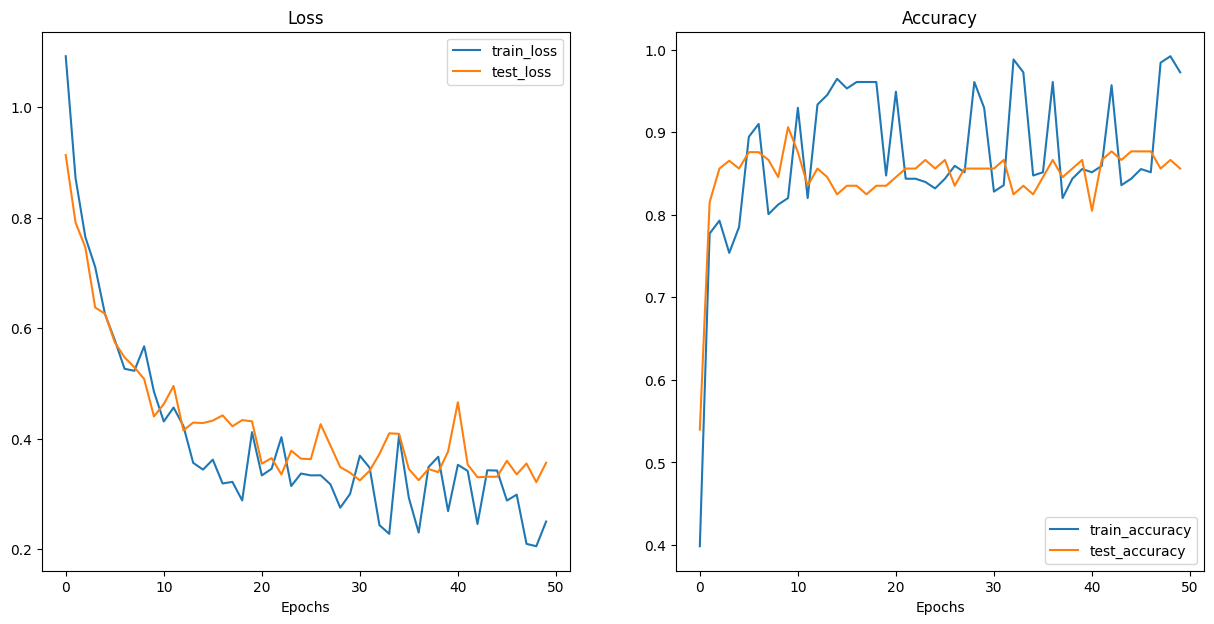

In [28]:
# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Make sure that our test data is:
* Same shape - images need to be the same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data should be on the same device as the model
* Same transform - transform the test data the same as trained data

In [36]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

# Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = "cpu"):

  # Open the image with PIL
  img = Image.open(image_path)

  # Create a transform if one doesn't exist:
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])])

  ### Predict on image
  # Make sure the model is on the target device
  model.to(device)

  # Turn on inference and eval mode
  model.eval()
  with torch.inference_mode():
    # Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0)
    # Make a prediction on the transformed image by passing it to the model (also ensure it's on the target device)
    target_image_pred = model(transformed_image.to(device))

  # Convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)

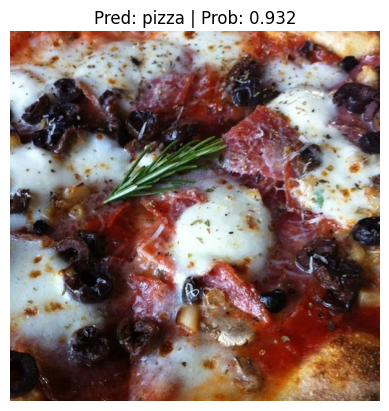

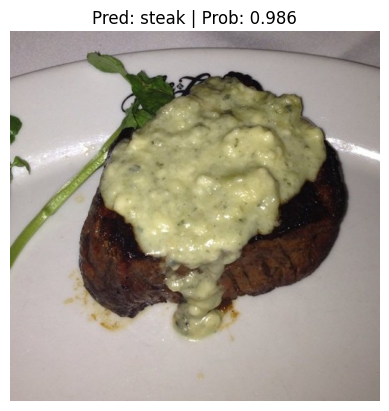

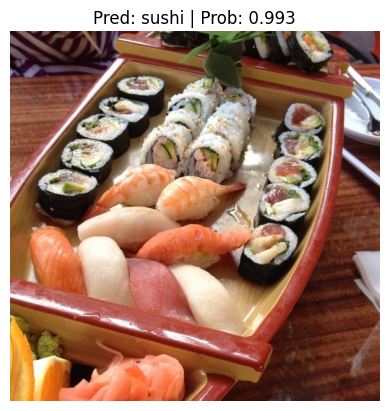

In [39]:
# Get a random list of image paths from the test set
import random

num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(256, 256),
                      device=device)